In [23]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
import sklearn
import os
from sklearn.model_selection import train_test_split
import ncg_optimizer
import torch
from torch.utils.data import Dataset, DataLoader

plt.ioff()
random_state = 12
keras.utils.set_random_seed(random_state)
torch.manual_seed(random_state)
b_code = '\u03B2'

|Имя|Тип данных|Измерение|Описание|
|--------|-----|-------|---------|
|Цемент|float|кг в м3 смеси|Вход|
|Доменный шлак|float|кг в м3 смеси|Вход|
|Летучая зола|float|кг в м3 смеси|Вход|
|Вода|float|кг в м3 смеси|Вход|
|Супер пластификатор|float|кг в м3 смеси|Вход|
|Крупный заполнитель|float|кг в м3 смеси|Вход|
|Мелкий заполнитель|float|кг в м3 смеси|Вход|
|Возраст|int|День (1~365)|Вход|
|Прочность на сжатие|float|Мпа|Выход|

Количество – 1030. Пропусков нет. Задача регрессии

# Чтение


In [24]:
df = pd.read_excel('Concrete_data.xls')
df.head()

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


In [25]:
df = df.set_axis(['cement', 'slag', 'ash', 'water', 'plastic', 'coarse', 'fine', 'age', 'strength'], axis=1)
df.head()

,cement,slag,ash,water,plastic,coarse,fine,age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


In [26]:
def clear_plt():
    allfignums = plt.get_fignums()
    for i in allfignums:
        fig = plt.figure(i)
        fig.clear()
        plt.close(fig)

In [27]:
for i in range(1, 17):
    os.makedirs('4.' + str(i), exist_ok=True)
    os.makedirs('4.' + str(i) + '/models/', exist_ok=True)
os.makedirs('1', exist_ok=True)
os.makedirs('1/boxplots', exist_ok=True)
os.makedirs('2', exist_ok=True)
os.makedirs('2/boxplots_clean', exist_ok=True)

# 1. Визуализация


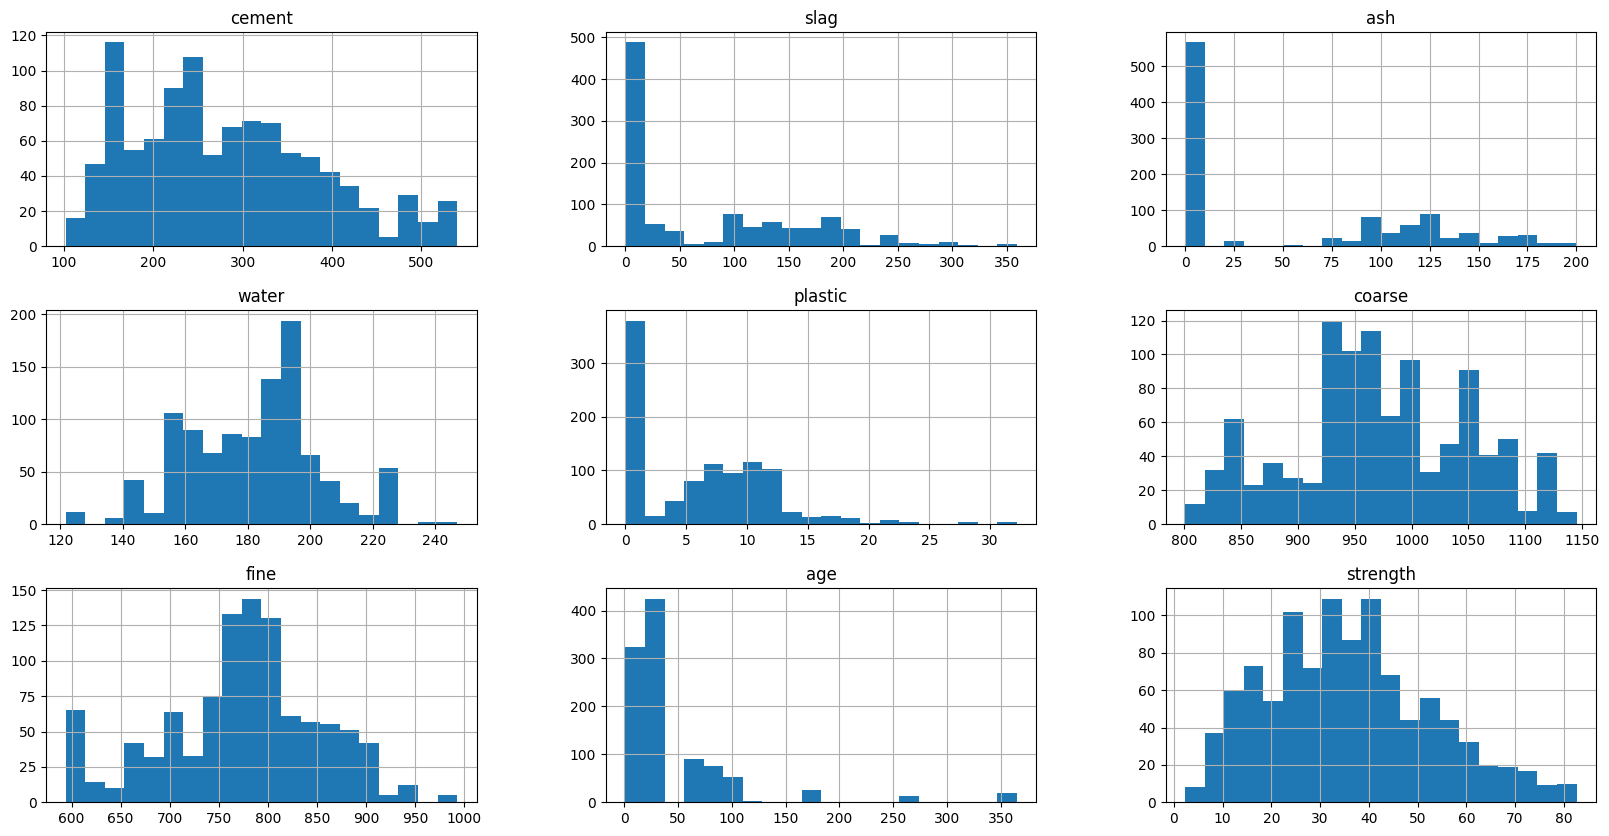

In [7]:
df.hist(figsize=(20, 10), bins=20)
plt.savefig('1/hist.png')

In [8]:
print(len(df))
df.isnull().sum()

1030


cement      0
slag        0
ash         0
water       0
plastic     0
coarse      0
fine        0
age         0
strength    0
dtype: int64

In [64]:
for c_name in df.columns:
    fig, ax = plt.subplots()
    sns.boxplot(data=df[c_name], ax=ax)
    ax.set_title(c_name)
    plt.savefig(f'1/boxplots/{c_name}_boxplot.png')
clear_plt()

In [65]:
fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(8)
sns.heatmap(df.corr(), cmap='coolwarm', ax=ax, annot=True)
fig.savefig('1/heatmap.png')
clear_plt()

In [9]:
sns.pairplot(df)
plt.savefig('1/pairplot.png')
clear_plt()

# 2. Предобработка данных


### 2.1 Очистка данных


удаление дубликатов


In [28]:
print(df.duplicated().sum())
df.drop_duplicates(inplace=True)
print(df.duplicated().sum())

25
0


удаление выбросов


In [29]:
print(len(df))
z = np.abs(stats.zscore(df))
df_clean = df[(z < 3).all(axis=1)]
print(len(df) - len(df_clean))

1005
49


In [30]:
df = df_clean

### 2.2 Преобразование данных


In [31]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[df.columns] = scaler.fit_transform(df[df.columns])

In [72]:
for c_name in df.columns:
    fig, ax = plt.subplots()
    sns.boxplot(data=df[c_name], ax=ax)
    ax.set_title(c_name)
    plt.savefig(f'2/boxplots_clean/{c_name}_boxplot.png')
clear_plt()

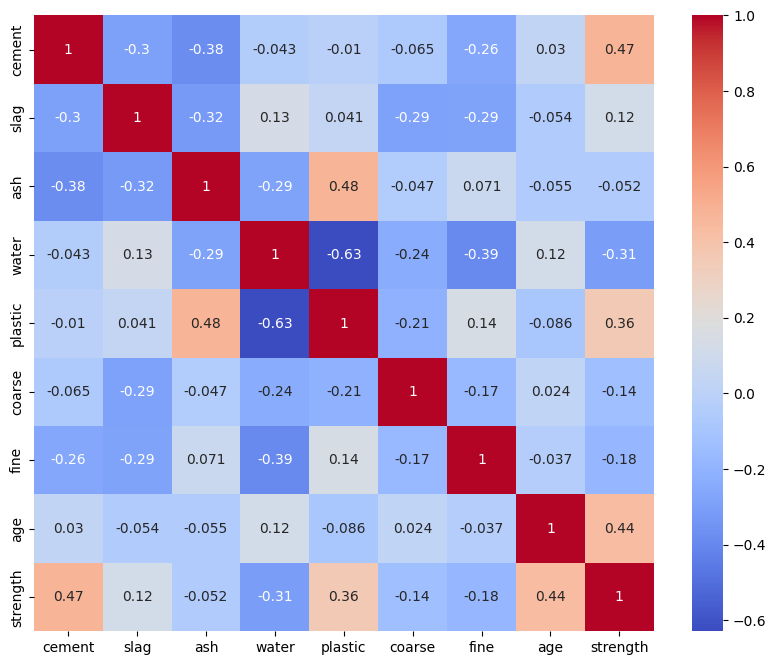

In [77]:
fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(8)
sns.heatmap(df.corr(), cmap='coolwarm', ax=ax, annot=True)
fig.savefig('2/heatmap_clean.png')
plt.show('2/heatmap_clean.png')

In [ ]:
sns.pairplot(df)
plt.savefig('2/pairplot.png')
clear_plt()

# 3. Формирование признаков


In [32]:
df = df.reindex(np.random.permutation(df.index))
df.reset_index(drop=True, inplace=True)
new_df = df.drop(columns=['ash'])

# 4. Построение и исследование нейросетевых моделей

In [33]:
n = len(new_df)
n_train = int(n * 0.6)
n_validate = int(n * 0.3)
n_test = n - n_train - n_validate
print(n_train, n_validate, n_test)

573 286 97


In [34]:
train, validate, test = np.array_split(new_df, (n_train, n_validate + n_train))

In [35]:
y_train = train['strength']
x_train = train.drop(columns=['strength'])

y_validate = validate['strength']
x_validate = validate.drop(columns=['strength'])

y_test = test['strength']
x_test = test.drop(columns=['strength'])

input_shape = len(x_train.columns)

In [36]:
class WeightsAndLossHistory(keras.callbacks.Callback):
    def __init__(self, x_test, y_test):
        super().__init__()
        self.weights = None
        self.test_losses = None
        self.x_test = x_test
        self.y_test = y_test

    def on_train_begin(self, logs=None):
        self.weights = [list(), list(), list(), list(), list(), list()]
        self.test_losses = list()

    def on_epoch_begin(self, epoch, logs=None):
        if logs is None:
            logs = {}
        weights = self.model.layers[0].get_weights()
        for i in range(3):
            self.weights[i].append(weights[0][0][i])
        weights = self.model.layers[1].get_weights()
        for i in range(3):
            self.weights[i + 3].append(weights[0][0][i])
        self.test_losses.append(
            tf.losses.mse(self.y_test, self.model.predict(self.x_test, verbose=0).reshape(-1)).numpy())

In [37]:
def plot_losses(history, test_losses: np.array, filename: str, title: str = None):
    fig = plt.figure(figsize=(12, 6))
    if title is not None:
        plt.title(title)
    plt.plot(history.history['loss'], label='train mse')
    plt.plot(history.history['val_loss'], label='validate mse')
    plt.plot(test_losses, label='test mse')
    plt.ylabel('error')
    plt.xlabel('epoch')
    plt.legend()
    plt.grid()
    plt.savefig(filename)

    fig.clear()
    plt.close(fig)


def plot_weights(weights: np.array, filename: str, title: str = None):
    fig = plt.figure(figsize=(12, 6))
    for i in range(len(weights)):
        plt.plot(weights[i], label=f'$w_{i}$')
    if title is not None:
        plt.title(title)
    plt.ylabel('weight')
    plt.xlabel('epoch')
    plt.legend()
    plt.grid()
    plt.savefig(filename)

    fig.clear()
    plt.close(fig)

### Тестовые запуски

#### Keras

In [38]:
class KerasTrainer:
    def __init__(self, x_train, y_train, x_validate, y_validate, x_test, y_test):
        self.x_train = x_train
        self.y_train = y_train

        self.x_val = x_validate
        self.y_val = y_validate

        self.x_test = x_test
        self.y_test = y_test

    def fit(self, model, callbacks: list, path: str, epochs=500, batch_size=100) -> tuple[np.array, np.array, dict]:
        history = model.fit(self.x_train, self.y_train, epochs=epochs, batch_size=batch_size,
                            validation_data=(self.x_val, self.y_val),
                            use_multiprocessing=True, workers=-1,
                            callbacks=callbacks, verbose=0)

        model.load_weights(path)
        train_pred = model.predict(self.x_train, verbose=0).reshape(-1)
        test_pred = model.predict(self.x_test, verbose=0).reshape(-1)

        return train_pred, test_pred, history
    
keras_trainer = KerasTrainer(x_train, y_train, x_validate, y_validate, x_test, y_test)

In [84]:
model = keras.Sequential(
    [keras.layers.Dense(20, input_dim=input_shape, use_bias=True, activation=tf.nn.sigmoid),
     keras.layers.Dense(20, use_bias=True, activation=tf.nn.sigmoid),
     keras.layers.Dropout(0.3),
     keras.layers.Dense(1, use_bias=True)])
model.compile(optimizer=tf.optimizers.Adam(0.01), loss=tf.losses.mse)
path = '4.1/models/keras_model.h5'
bad_callback = WeightsAndLossHistory(x_test, y_test)
callbacks = [keras.callbacks.EarlyStopping(patience=30, monitor='val_loss'),
            keras.callbacks.ModelCheckpoint(path, monitor='val_loss', save_best_only=True, mode='min', save_weights_only=True),
            bad_callback]

In [85]:
train_pred, test_pred, history = keras_trainer.fit(model, callbacks, path, epochs=300)

In [86]:
plot_losses(history, bad_callback.test_losses, '4.1/keras_fit_model.png')
print(f'Loss on train: {tf.losses.mse(y_train, train_pred)}')
print(f'Loss on test: {tf.losses.mse(y_test, test_pred)}')

Loss on train: 0.11780796945095062
Loss on test: 0.14229422807693481


#### Torch

In [39]:
# Dataset from DataFrame
class TorchData(Dataset):
    def __init__(self, x: pd.DataFrame, y: pd.DataFrame):
        self.X = torch.tensor(x.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

    def get_x(self):
        return self.X

    def get_y(self):
        return self.y


class Net(torch.nn.Module):
    def __init__(self, input_shape, n1=20, n2=20):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(input_shape, n1)
        self.fc2 = torch.nn.Linear(n1, n2)
        self.fc3 = torch.nn.Linear(n2, 1)

        torch.nn.init.xavier_normal_(self.fc1.weight)
        torch.nn.init.xavier_normal_(self.fc2.weight)
        torch.nn.init.xavier_normal_(self.fc3.weight)

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x.view(-1)


class TorchTrainer:
    def __init__(self, net, loss_f, optimizer,
                 epoch_amount=10, batch_size=50,
                 early_stopping=50,
                 verbose=1):

        self.loss_function = loss_f()
        self.epoch_amount = epoch_amount
        self.batch_size = batch_size

        self.early_stopping = early_stopping
        self.optimizer = optimizer
        self.scheduler = None

        self.start_model = net
        self.best_model = net

        self.verbose = verbose

        self.train_loss = []
        self.val_loss = []

    def evaluate(self, test: TorchData):
        self.best_model.eval()
        with torch.no_grad():
            return self.loss_function(self.best_model(test.get_x()), test.get_y()).item()

    def evaluate_all(self, train: TorchData, val: TorchData, test: TorchData):
        self.best_model.eval()
        with torch.no_grad():
            train_loss = self.loss_function(self.best_model(train.get_x()), train.get_y()).item()
            val_loss = self.loss_function(self.best_model(val.get_x()), val.get_y()).item()
            test_loss = self.loss_function(self.best_model(test.get_x()), test.get_y()).item()
            print(f'Loss on train: {train_loss:.3f}')
            print(f'Loss on validate: {val_loss:.3f}')
            print(f'Loss on test: {test_loss:.3f}')

    def fit(self, train_data: Dataset, val_data: Dataset):
        Net = self.start_model
        # optimizer = self.optim([p for p in Net.parameters() if p.requires_grad], lr=self.learning_rate)

        if self.scheduler is not None:
            scheduler = self.scheduler(self.optimizer)

        train = DataLoader(train_data, batch_size=self.batch_size, shuffle=True)
        val = DataLoader(val_data, batch_size=self.batch_size, shuffle=False)

        best_val_loss = float('inf')
        best_ep = 0

        for epoch in range(self.epoch_amount):
            if self.verbose != 0:
                print(f'Эпоха: {epoch}', end=' ')
            Net.train()
            mean_loss = 0

            for batch_X, target in train:
                self.optimizer.zero_grad()
                predicted_values = Net(batch_X)
                loss = self.loss_function(predicted_values, target)
                loss.backward()
                self.optimizer.step()

                mean_loss += loss.item()

            mean_loss /= len(train)
            self.train_loss.append(mean_loss)

            if self.verbose != 0:
                print(f'Loss_train: {mean_loss}')

            Net.eval()
            mean_loss = 0

            with torch.no_grad():
                for batch_X, target in val:
                    predicted_values = Net(batch_X)
                    loss = self.loss_function(predicted_values, target)
                    mean_loss += float(loss)

            mean_loss /= len(val)
            self.val_loss.append(mean_loss)
            if self.verbose != 0:
                print(f'Loss_val: {mean_loss}')

            if mean_loss < best_val_loss:
                self.best_model = Net
                best_val_loss = mean_loss
                best_ep = epoch
            elif epoch - best_ep > self.early_stopping:
                if self.verbose != 0:
                    print(f'{self.early_stopping} без улучшений. Прекращаем обучение...')
                break
            if self.scheduler is not None:
                scheduler.step()

            if self.verbose != 0:
                print()

        self.best_model.eval()

    def fit_clousure(self, train_data: Dataset, val_data: Dataset):
        Net = self.start_model

        if self.scheduler is not None:
            scheduler = self.scheduler(self.optimizer)

        train = DataLoader(train_data, batch_size=self.batch_size, shuffle=True)
        val = DataLoader(val_data, batch_size=self.batch_size, shuffle=False)

        best_val_loss = float('inf')
        best_ep = 0

        for epoch in range(self.epoch_amount):
            if self.verbose != 0:
                print(f'Эпоха: {epoch}')
            Net.train()
            mean_loss = 0

            for x, target in train_data:
                X_ = torch.autograd.Variable(x.float(), requires_grad=True)
                y_ = torch.autograd.Variable(target.float())

                # print(f'y = {y_}')
                # print(f'pred = {Net(X_)[0]}')
                def closure():
                    self.optimizer.zero_grad()
                    predicted_values = Net(X_)
                    loss = self.loss_function(predicted_values.squeeze(), y_)
                    if loss.requires_grad:
                        loss.backward()
                    return loss

                self.optimizer.step(closure)

                with torch.no_grad():
                    predicted_values = Net(x)
                    loss = self.loss_function(predicted_values.squeeze(), target)
                    mean_loss += loss.item()

            mean_loss /= len(train_data)
            self.train_loss.append(mean_loss)

            if self.verbose != 0:
                print(f'Loss_train: {mean_loss}')

            Net.eval()
            mean_loss = 0

            with torch.no_grad():
                for batch_X, target in val:
                    predicted_values = Net(batch_X)
                    loss = self.loss_function(predicted_values, target)
                    mean_loss += float(loss)

            mean_loss /= len(val)
            self.val_loss.append(mean_loss)
            if self.verbose != 0:
                print(f'Loss_val: {mean_loss}')

            if mean_loss < best_val_loss:
                self.best_model = Net
                best_val_loss = mean_loss
                best_ep = epoch
            elif epoch - best_ep > self.early_stopping:
                break
            if self.scheduler is not None:
                scheduler.step()

            if self.verbose != 0:
                print()

        self.best_model.eval()

    def fit_minimizer(self, train_data: Dataset, val_data: Dataset):
        Net = self.start_model

        if self.scheduler is not None:
            scheduler = self.scheduler(self.optimizer)

        train = DataLoader(train_data, batch_size=self.batch_size, shuffle=True)
        val = DataLoader(val_data, batch_size=self.batch_size, shuffle=False)

        best_val_loss = float('inf')
        best_ep = 0

        for epoch in range(self.epoch_amount):
            if self.verbose != 0:
                print(f'Эпоха: {epoch}')
            Net.train()
            mean_loss = 0

            for x, target in train_data:
                X_ = torch.autograd.Variable(x.float(), requires_grad=True)
                y_ = torch.autograd.Variable(target.float())

                def closure():
                    self.optimizer.zero_grad()
                    predicted_values = Net(X_)
                    loss = self.loss_function(predicted_values.squeeze(), y_)
                    return loss

                self.optimizer.step(closure)

                with torch.no_grad():
                    predicted_values = Net(x)
                    loss = self.loss_function(predicted_values.squeeze(), target)
                    mean_loss += loss.item()

            mean_loss /= len(train_data)
            self.train_loss.append(mean_loss)

            if self.verbose != 0:
                print(f'Loss_train: {mean_loss}')

            Net.eval()
            mean_loss = 0

            with torch.no_grad():
                for batch_X, target in val:
                    predicted_values = Net(batch_X)
                    loss = self.loss_function(predicted_values, target)
                    mean_loss += float(loss)

            mean_loss /= len(val)
            self.val_loss.append(mean_loss)
            if self.verbose != 0:
                print(f'Loss_val: {mean_loss}')

            if mean_loss < best_val_loss:
                self.best_model = Net
                best_val_loss = mean_loss
                best_ep = epoch
            elif epoch - best_ep > self.early_stopping:
                break
            if self.scheduler is not None:
                scheduler.step()

            if self.verbose != 0:
                print()

        self.best_model.eval()

    def plot_torch_losses(self, filename, title=None):
        fig = plt.figure(figsize=(12, 6))
        if title is not None:
            plt.title(title)
        plt.plot(self.train_loss, label='train mse')
        plt.plot(self.val_loss, label='validate mse')
        plt.ylabel('error')
        plt.xlabel('epoch')
        plt.legend()
        plt.grid()
        plt.savefig(filename)

        fig.clear()
        plt.close(fig)

In [40]:
torch_train = TorchData(x_train, y_train)
torch_val = TorchData(x_validate, y_validate)
torch_test = TorchData(x_test, y_test)

In [ ]:
net = Net(len(x_train.columns))

params = {
    'net': net,
    'epoch_amount': 3,
    'early_stopping': 30,
    'loss_f': torch.nn.MSELoss,
    # 'optimizer': torch.optim.LBFGS(net.parameters(), lr=0.5, max_iter=4, line_search_fn='strong_wolfe'),
    'optimizer': ncg_optimizer.BASIC(net.parameters(), method='FR', c1=1e-4,
                                     c2=0.2, lr=10, rho=0.1, max_ls=500),
    # 'optimizer': torch.optim.Adam(net.parameters(),lr=0.005),
    'verbose': 1,
}

clf = TorchTrainer(**params)
clf.fit_clousure(torch_train, torch_val)

In [49]:
clf.evaluate_all(torch_train, torch_val, torch_test)
clf.plot_torch_losses('4.1/torch_fit_model.png')

Loss on train: 115.647
Loss on validate: 174.824
Loss on test: 157.084


### 4.2 Перебор learning rate

In [32]:
for lr in [0.1, 0.05, 0.01, 0.005, 0.001]:
    path = f'4.2/models/GD_{lr}.h5'
    model = keras.Sequential(
        [keras.layers.Dense(20, input_dim=input_shape, use_bias=True, activation=tf.nn.sigmoid),
         keras.layers.Dense(20, use_bias=True, activation=tf.nn.sigmoid),
         keras.layers.Dropout(0.3),
         keras.layers.Dense(1, use_bias=True)])
    
    def scheduler(epoch, lr_):
        return lr
    lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

    model.compile(optimizer=tf.optimizers.Adagrad(lr), loss=tf.losses.mse)
    bad_callback = WeightsAndLossHistory(x_test, y_test)
    callbacks = [keras.callbacks.EarlyStopping(patience=30, monitor='val_loss'),
                 keras.callbacks.ModelCheckpoint(path, monitor='val_loss', save_best_only=True, mode='min', save_weights_only=True),
                 bad_callback, lr_scheduler]
    
    train_pred, test_pred, history = keras_trainer.fit(model, callbacks, path, epochs=300)

    print(f'lr: {lr:.3f}')
    print(f'Loss on train: {tf.losses.mse(y_train, train_pred):.3f}')
    print(f'Loss on test: {tf.losses.mse(y_test, test_pred):.3f}')

    plot_losses(history, bad_callback.test_losses, f'4.2/fit_model_{lr}.png', f'GD, lr = {lr}')
clear_plt()

lr: 0.100
Loss on train: 0.170
Loss on test: 0.168
lr: 0.050
Loss on train: 0.190
Loss on test: 0.182
lr: 0.010
Loss on train: 0.322
Loss on test: 0.317
lr: 0.005
Loss on train: 0.450
Loss on test: 0.448
lr: 0.001
Loss on train: 0.944
Loss on test: 0.895


In [41]:
GD_lr = 0.1

### 4.3 Перебор момента для NAG и GDM


#### GDM:


In [88]:
for mu in [0, 0.6, 0.8, 0.9, 0.95]:
    path = f'4.3/models/gdm_{mu}.h5'
    model = keras.Sequential(
        [keras.layers.Dense(20, input_dim=input_shape, use_bias=True, activation=tf.nn.sigmoid),
         keras.layers.Dense(20, use_bias=True, activation=tf.nn.sigmoid),
         keras.layers.Dropout(0.3),
         keras.layers.Dense(1, use_bias=True)])
    model.compile(optimizer=tf.optimizers.SGD(GD_lr, momentum=mu), loss=tf.losses.mse)
    bad_callback = WeightsAndLossHistory(x_test, y_test)
    callbacks = [keras.callbacks.EarlyStopping(patience=30, monitor='val_loss'),
                 keras.callbacks.ModelCheckpoint(path, monitor='val_loss', save_best_only=True, mode='min', save_weights_only=True),
                 bad_callback]

    train_pred, test_pred, history = keras_trainer.fit(model, callbacks, path, epochs=300)
    
    print(f'mu: {mu:.3f}')
    print(f'Loss on train: {tf.losses.mse(y_train, train_pred):.3f}')
    print(f'Loss on test: {tf.losses.mse(y_test, test_pred):.3f}')

    plot_losses(history, bad_callback.test_losses, f'4.3/fit_model_GDM_{mu}.png', f'GDM, mu = {mu}')
clear_plt()

mu: 0.000
Loss on train: 0.191
Loss on test: 0.187
mu: 0.600
Loss on train: 0.167
Loss on test: 0.160
mu: 0.800
Loss on train: 0.151
Loss on test: 0.166
mu: 0.900
Loss on train: 0.146
Loss on test: 0.158
mu: 0.950
Loss on train: 0.103
Loss on test: 0.164


In [49]:
for mu in [0, 0.6, 0.8, 0.9, 0.95]:
    net = Net(len(x_train.columns))

    params = {
        'net': net,
        'epoch_amount': 70,
        'early_stopping': 20,
        'loss_f': torch.nn.MSELoss,
        'optimizer': torch.optim.SGD(net.parameters(), lr=GD_lr, momentum=mu),
        'verbose': 0,
    }

    clf = TorchTrainer(**params)
    clf.fit(torch_train, torch_val)
    print(f'mu: {mu:.3f}')
    clf.evaluate_all(torch_train, torch_val, torch_test)
    print()
    clf.plot_torch_losses(f'4.3/fit_model_GDM_{mu}.png', f'GDM, mu = {mu}')

mu: 0.000
Loss on train: 0.250
Loss on validate: 0.251
Loss on test: 0.235

mu: 0.100
Loss on train: 0.207
Loss on validate: 0.219
Loss on test: 0.209

mu: 0.300
Loss on train: 0.190
Loss on validate: 0.195
Loss on test: 0.176

mu: 0.600
Loss on train: 0.183
Loss on validate: 0.189
Loss on test: 0.168

mu: 0.800
Loss on train: 0.162
Loss on validate: 0.174
Loss on test: 0.165

mu: 0.950
Loss on train: 0.135
Loss on validate: 0.181
Loss on test: 0.184



#### NAG:


In [89]:
for mu in [0, 0.6, 0.8, 0.9, 0.95]:
    path = f'4.3/models/nag_{mu}.h5'
    model = keras.Sequential(
        [keras.layers.Dense(20, input_dim=input_shape, use_bias=True, activation=tf.nn.sigmoid),
         keras.layers.Dense(20, use_bias=True, activation=tf.nn.sigmoid),
         keras.layers.Dropout(0.3),
         keras.layers.Dense(1, use_bias=True)])
    model.compile(optimizer=tf.optimizers.SGD(GD_lr, momentum=mu, nesterov=True), loss=tf.losses.mse)
    bad_callback = WeightsAndLossHistory(x_test, y_test)
    callbacks = [keras.callbacks.EarlyStopping(patience=30, monitor='val_loss'),
                 keras.callbacks.ModelCheckpoint(path, monitor='val_loss', save_best_only=True, mode='min', save_weights_only=True),
                 bad_callback]

    train_pred, test_pred, history = keras_trainer.fit(model, callbacks, path, epochs=300)
    
    print(f'mu: {mu:.3f}')
    print(f'Loss on train: {tf.losses.mse(y_train, train_pred):.3f}')
    print(f'Loss on test: {tf.losses.mse(y_test, test_pred):.3f}')

    plot_losses(history, bad_callback.test_losses, f'4.3/fit_model_NAG_{mu}.png', f'NAG, mu = {mu}')

clear_plt()

mu: 0.000
Loss on train: 0.193
Loss on test: 0.183
mu: 0.600
Loss on train: 0.168
Loss on test: 0.162
mu: 0.800
Loss on train: 0.145
Loss on test: 0.155
mu: 0.900
Loss on train: 0.149
Loss on test: 0.154
mu: 0.950
Loss on train: 0.113
Loss on test: 0.147


In [53]:
for mu in [0.1, 0.6, 0.8, 0.9, 0.95]:
    net = Net(len(x_train.columns))

    params = {
        'net': net,
        'epoch_amount': 70,
        'early_stopping': 20,
        'loss_f': torch.nn.MSELoss,
        'optimizer': torch.optim.SGD(net.parameters(), lr=GD_lr, momentum=mu, nesterov=True),
        'verbose': 0,
    }

    clf = TorchTrainer(**params)
    clf.fit(torch_train, torch_val)
    print(f'mu: {mu:.3f}')
    clf.evaluate_all(torch_train, torch_val, torch_test)
    print()
    clf.plot_torch_losses(f'4.3/fit_model_NAG_{mu}.png', f'NAG, mu = {mu}')

mu: 0.100
Loss on train: 0.241
Loss on validate: 0.258
Loss on test: 0.238

mu: 0.600
Loss on train: 0.166
Loss on validate: 0.172
Loss on test: 0.160

mu: 0.800
Loss on train: 0.175
Loss on validate: 0.191
Loss on test: 0.184

mu: 0.900
Loss on train: 0.124
Loss on validate: 0.152
Loss on test: 0.148

mu: 0.950
Loss on train: 0.112
Loss on validate: 0.159
Loss on test: 0.174



### 4.4 Исследование методов наискорейшего спуска и сопряжённых градиентов


#### Метод наискорейшего спуска


In [55]:
path = '4.4/models/SGD.h5'
model = keras.Sequential(
    [keras.layers.Dense(20, input_dim=input_shape, use_bias=True, activation=tf.nn.sigmoid),
     keras.layers.Dense(20, use_bias=True, activation=tf.nn.sigmoid),
     keras.layers.Dropout(0.3),
     keras.layers.Dense(1, use_bias=True)])
model.compile(optimizer=tf.optimizers.SGD(GD_lr), loss=tf.losses.mse)
bad_callback = WeightsAndLossHistory(x_test, y_test)
callbacks = [keras.callbacks.EarlyStopping(patience=30, monitor='val_loss'),
             keras.callbacks.ModelCheckpoint(path, monitor='val_loss', save_best_only=True, mode='min', save_weights_only=True),
             bad_callback]

train_pred, test_pred, history = keras_trainer.fit(model, callbacks, path, epochs=300)

print(f'Loss on train: {tf.losses.mse(y_train, train_pred):.3f}')
print(f'Loss on test: {tf.losses.mse(y_test, test_pred):.3f}')

plot_losses(history, bad_callback.test_losses, f'4.4/fit_model_SGD.png', f'SGD, lr = {GD_lr}')
clear_plt()

Loss on train: 0.138
Loss on test: 0.152


#### Флэтчер-Ривс


In [22]:
from torchmin import Minimizer

net = Net(len(x_train.columns))

params = {
    'net': net,
    'epoch_amount': 4,
    'early_stopping': 10,
    'loss_f': torch.nn.MSELoss,
    'optimizer': Minimizer(net.parameters(), method='fr'),
    'verbose': 1,
}

clf = TorchTrainer(**params)
clf.fit_minimizer(torch_train, torch_val)
clf.evaluate_all(torch_train, torch_val, torch_test)
clf.plot_torch_losses(f"4.4/fit_model_FR.png", "FR")

Эпоха: 0
Loss_train: 6.023625520832777e-13
Loss_val: 0.36414703726768494

Эпоха: 1
Loss_train: 3.8593586475985087e-13
Loss_val: 0.4108356336752574

Эпоха: 2
Loss_train: 7.498188205852683e-13
Loss_val: 0.42005740602811176

Эпоха: 3
Loss_train: 7.109120143666655e-13
Loss_val: 0.4336146016915639

Loss on train: 0.427
Loss on validate: 0.434
Loss on test: 0.364


#### Полак-Райбер


In [29]:
from torchmin import Minimizer

net = Net(len(x_train.columns))

params = {
    'net': net,
    'epoch_amount': 7,
    'early_stopping': 10,
    'loss_f': torch.nn.MSELoss,
    'optimizer': Minimizer(net.parameters(),method='cg'),
    'verbose': 1,
}

clf = TorchTrainer(**params)
clf.fit_minimizer(torch_train, torch_val)
clf.evaluate_all(torch_train, torch_val, torch_test)
clf.plot_torch_losses(f"4.4/fit_model_PR.png", "PR")

Эпоха: 0
Loss_train: 9.64197502786627e-13
Loss_val: 0.4452766180038452

Эпоха: 1
Loss_train: 8.85167602669957e-13
Loss_val: 0.4151034702857335

Эпоха: 2
Loss_train: 6.283603442073482e-13
Loss_val: 0.4225112646818161

Эпоха: 3
Loss_train: 1.2428276938587492e-12
Loss_val: 0.4715741276741028

Эпоха: 4
Loss_train: 1.0934144713717114e-12
Loss_val: 0.48977285623550415

Эпоха: 5
Loss_train: 8.238102456233389e-13
Loss_val: 0.45300065477689105

Эпоха: 6
Loss_train: 1.0249066567358666e-12
Loss_val: 0.5149538218975067

Loss on train: 0.517
Loss on validate: 0.519
Loss on test: 0.495


### 4.5 Исследование метода AdaGrad


In [90]:
path = '4.5/models/adagrad.h5'
model = keras.Sequential(
    [keras.layers.Dense(20, input_dim=input_shape, use_bias=True, activation=tf.nn.sigmoid),
     keras.layers.Dense(20, use_bias=True, activation=tf.nn.sigmoid),
     keras.layers.Dropout(0.3),
     keras.layers.Dense(1, use_bias=True)])

bad_callback = WeightsAndLossHistory(x_test, y_test)

model.compile(optimizer=tf.optimizers.Adagrad(0.05), loss=tf.losses.mse)
callbacks = [keras.callbacks.EarlyStopping(patience=30, monitor='val_loss'),
             keras.callbacks.ModelCheckpoint(path, monitor='val_loss', save_best_only=True, mode='min', save_weights_only=True),
             bad_callback]

train_pred, test_pred, history = keras_trainer.fit(model, callbacks, path, epochs=300)

print(f'Loss on train: {tf.losses.mse(y_train, train_pred):.3f}')
print(f'Loss on test: {tf.losses.mse(y_test, test_pred):.3f}')

plot_losses(history, bad_callback.test_losses, f'4.5/fit_model_AdaGrad.png', f'AdaGrad')
plot_weights(bad_callback.weights, f"4.5/weights_AdaGrad.png", f'AdaGrad')

Loss on train: 0.190
Loss on test: 0.181


### 4.6 Исследование методов RMSProp и AdaDelta


#### RMSProp


In [92]:
for rho in [0, 0.4, 0.8, 0.9, 0.95]:
    path = f'4.6/models/rmspop_{rho}.h5'
    model = keras.Sequential(
        [keras.layers.Dense(20, input_dim=input_shape, use_bias=True, activation=tf.nn.sigmoid),
         keras.layers.Dense(20, use_bias=True, activation=tf.nn.sigmoid),
         keras.layers.Dropout(0.3),
         keras.layers.Dense(1, use_bias=True)])

    bad_callback = WeightsAndLossHistory(x_test, y_test)

    model.compile(optimizer=tf.optimizers.RMSprop(0.01, rho=rho), loss=tf.losses.mse)
    callbacks = [keras.callbacks.EarlyStopping(patience=30, monitor='val_loss'),
                 keras.callbacks.ModelCheckpoint(path, monitor='val_loss', save_best_only=True, mode='min', save_weights_only=True),
                 bad_callback]
    
    train_pred, test_pred, history = keras_trainer.fit(model, callbacks, path, epochs=300)

    print(f'rho = {rho}')
    print(f'Loss on train: {tf.losses.mse(y_train, train_pred):.3f}')
    print(f'Loss on test: {tf.losses.mse(y_test, test_pred):.3f}')

    plot_losses(history, bad_callback.test_losses, f"4.6/fit_model_rmsprop_rho({rho}).png", f'RMSprop, rho={rho}')
    plot_weights(bad_callback.weights, f"4.6/weights_rmsprop_rho({rho}).png", f'RMSprop, rho={rho}')

clear_plt()

rho = 0
Loss on train: 0.124
Loss on test: 0.139
rho = 0.4
Loss on train: 0.103
Loss on test: 0.146
rho = 0.8
Loss on train: 0.103
Loss on test: 0.129
rho = 0.9
Loss on train: 0.108
Loss on test: 0.148
rho = 0.95
Loss on train: 0.104
Loss on test: 0.148


#### AdaDelta


In [24]:
for rho in [0, 0.4, 0.8, 0.9, 0.95]:
    path = f'4.6/models/adadelta_{rho}.h5'
    model = keras.Sequential(
        [keras.layers.Dense(20, input_dim=input_shape, use_bias=True, activation=tf.nn.sigmoid),
         keras.layers.Dense(20, use_bias=True, activation=tf.nn.sigmoid),
         keras.layers.Dropout(0.3),
         keras.layers.Dense(1, use_bias=True)])

    bad_callback = WeightsAndLossHistory(x_test, y_test)

    model.compile(optimizer=tf.optimizers.Adadelta(0.1, rho=rho), loss=tf.losses.mse)
    callbacks = [keras.callbacks.EarlyStopping(patience=30, monitor='val_loss'),
                 keras.callbacks.ModelCheckpoint(path, monitor='val_loss', save_best_only=True, mode='min', save_weights_only=True),
                 bad_callback]
    
    train_pred, test_pred, history = keras_trainer.fit(model, callbacks, path, epochs=300)

    print(f'rho = {rho}')
    print(f'Loss on train: {tf.losses.mse(y_train, train_pred):.3f}')
    print(f'Loss on test: {tf.losses.mse(y_test, test_pred):.3f}')

    plot_losses(history, bad_callback.test_losses, f"4.6/fit_model_adadelta_rho({rho}).png", f'AdaDelta, rho={rho}')
    plot_weights(bad_callback.weights, f"4.6/weights_adadelta_rho({rho}).png", f'AdaDelta, rho={rho}')

clear_plt()

rho = 0
Loss on train: 0.316
Loss on test: 0.300
rho = 0.4
Loss on train: 0.701
Loss on test: 0.671
rho = 0.8
Loss on train: 0.638
Loss on test: 0.608
rho = 0.9
Loss on train: 0.487
Loss on test: 0.467
rho = 0.95
Loss on train: 0.372
Loss on test: 0.372


### 4.7 Исследование метода Adam


In [94]:
for beta_1, beta_2 in zip([0, 0.4, 0.6, 0.9, 0.9], [0, 0.4, 0.6, 0.9, 0.999]):
    path = f'4.7/models/adam_{beta_1}_{beta_2}.h5'
    model = keras.Sequential(
        [keras.layers.Dense(20, input_dim=input_shape, use_bias=True, activation=tf.nn.sigmoid),
         keras.layers.Dense(20, use_bias=True, activation=tf.nn.sigmoid),
         keras.layers.Dropout(0.3),
         keras.layers.Dense(1, use_bias=True)])

    bad_callback = WeightsAndLossHistory(x_test, y_test)

    model.compile(optimizer=tf.optimizers.Adam(0.01, beta_1=beta_1, beta_2=beta_2), loss=tf.losses.mse)
    callbacks = [keras.callbacks.EarlyStopping(patience=30, monitor='val_loss'),
                 keras.callbacks.ModelCheckpoint(path, monitor='val_loss', save_best_only=True, mode='min',
                                                 save_weights_only=True, initial_value_threshold=0.3),
                 bad_callback]
    
    train_pred, test_pred, history = keras_trainer.fit(model, callbacks, path, epochs=300)

    print(f'{b_code}1 = {beta_1}, {b_code}2 = {beta_2}')
    print(f'Loss on train: {tf.losses.mse(y_train, train_pred):.3f}')
    print(f'Loss on test: {tf.losses.mse(y_test, test_pred):.3f}')

    plot_losses(history, bad_callback.test_losses, f"4.7/fit_model_beta1({beta_1})_beta2({beta_2}).png",
                f'$Adam, {b_code}_1={beta_1}, {b_code}_2={beta_2}$')
    plot_weights(bad_callback.weights, f"4.7/weights_beta1({beta_1})_beta2({beta_2}).png",
                 f'$Adam, {b_code}_1={beta_1}, {b_code}_2={beta_2}$')

clear_plt()

β1 = 0, β2 = 0
Loss on train: 0.128
Loss on test: 0.147
β1 = 0.4, β2 = 0.4
Loss on train: 0.094
Loss on test: 0.147
β1 = 0.6, β2 = 0.6
Loss on train: 0.102
Loss on test: 0.142
β1 = 0.9, β2 = 0.9
Loss on train: 0.102
Loss on test: 0.150
β1 = 0.9, β2 = 0.999
Loss on train: 0.106
Loss on test: 0.142


### 4.8 Исследование метода RProp


In [103]:
net = Net(len(x_train.columns))

params = {
    'net': net,
    'epoch_amount': 300,
    'early_stopping': 30,
    'loss_f': torch.nn.MSELoss,
    'optimizer': torch.optim.Rprop(net.parameters(), lr=0.1),
    'verbose': 0,
}

clf = TorchTrainer(**params)
clf.fit(torch_train, torch_val)
clf.evaluate_all(torch_train, torch_val, torch_test)
clf.plot_torch_losses(f"4.8/fit_model_Rprop.png", "Rprop")

Loss on train: 0.293
Loss on validate: 0.282
Loss on test: 0.279


### 4.9. Исследование методов Левенберга-Маркардта и BFGS


#### Левендберг-Маркадарт

#### BFGS

In [30]:
from torchmin import Minimizer

net = Net(len(x_train.columns))

params = {
    'net': net,
    'epoch_amount': 2,
    'early_stopping': 10,
    'loss_f': torch.nn.MSELoss,
    'optimizer': Minimizer(net.parameters(), method='bfgs'),
    'verbose': 1,
}

clf = TorchTrainer(**params)
clf.fit_minimizer(torch_train, torch_val)
clf.evaluate_all(torch_train, torch_val, torch_test)
clf.plot_torch_losses(f"4.9/fit_model_bfgs.png", "BFGS")

Эпоха: 0
Loss_train: 6.827747865783791e-11
Loss_val: 0.2756896490852038

Эпоха: 1
Loss_train: 6.69454235658865e-11
Loss_val: 0.2611186703046163

Loss on train: 0.272
Loss on validate: 0.262
Loss on test: 0.261


### 4.10. Исследование метода стохастического градиента


In [ ]:
for batch_size in [1, 20, 50, 100, len(x_train)]:
    path = f'4.10/sgd_{batch_size}.h5'
    model = keras.Sequential(
        [keras.layers.Dense(20, input_dim=input_shape, use_bias=True, activation=tf.nn.sigmoid),
         keras.layers.Dense(20, use_bias=True, activation=tf.nn.sigmoid),
         keras.layers.Dropout(0.3),
         keras.layers.Dense(1, use_bias=True)])

    bad_callback = WeightsAndLossHistory(x_test, y_test)

    model.compile(optimizer=tf.optimizers.SGD(GD_lr), loss=tf.losses.mse)
    callbacks = [keras.callbacks.EarlyStopping(patience=30, monitor='val_loss'),
                  keras.callbacks.ModelCheckpoint(path, monitor='val_loss', save_best_only=True, mode='min', save_weights_only=True),
                  bad_callback]
    
    train_pred, test_pred, history = keras_trainer.fit(model, callbacks, path, epochs=300, batch_size=batch_size)

    print(f'batch_size = {batch_size}')
    print(f'Loss on train: {tf.losses.mse(y_train, train_pred):.3f}')
    print(f'Loss on test: {tf.losses.mse(y_test, test_pred):.3f}')

    plot_losses(history, bad_callback.test_losses, f"4.10/fit_model_size({batch_size}).png", f"SGD, batch_size = {batch_size}")

clear_plt()

In [115]:
for batch_size in [1, 20, 50, 100, len(x_train)]:
    net = Net(len(x_train.columns))

    params = {
        'net': net,
        'epoch_amount': 200,
        'early_stopping': 20,
        'loss_f': torch.nn.MSELoss,
        'optimizer': torch.optim.SGD(net.parameters(), lr=GD_lr),
        'batch_size': batch_size,
        'verbose': 0,
    }

    clf = TorchTrainer(**params)
    clf.fit(torch_train, torch_val)
    print(f'batch_size = {batch_size}')
    clf.evaluate_all(torch_train, torch_val, torch_test)
    print()
    clf.plot_torch_losses(f"4.10/fit_model_size({batch_size}).png", f"SGD, batch_size = {batch_size}")

batch_size = 1
Loss on train: 0.083
Loss on validate: 0.133
Loss on test: 0.183

batch_size = 20
Loss on train: 0.146
Loss on validate: 0.179
Loss on test: 0.176

batch_size = 50
Loss on train: 0.199
Loss on validate: 0.207
Loss on test: 0.195

batch_size = 100
Loss on train: 0.175
Loss on validate: 0.177
Loss on test: 0.163

batch_size = 573
Loss on train: 0.300
Loss on validate: 0.288
Loss on test: 0.304



### 4.11. Сравнение методов обучения


|Метод|lr|parametrs|
|-----|---|---------|
|SGD|0.1|-|
|GDM|0.1|$\mu = 0.9$|
|NAG|0.1|$\mu = 0.9$|
|Adagrad|0.05|-|
|Adadelta|0.1|$\rho=0$|
|RMSprop|0.01|$\rho=0.95$|
|Adam|0.01|$\beta_1=0.9, \beta_2=0.999$| 
|Rprop|0.1|-|

In [124]:
import keras.optimizers as opt

optimizers = [opt.Adam(0.01, beta_1=0.9, beta_2=0.999), opt.Adadelta(0.1, rho=0), opt.Adagrad(0.05), opt.SGD(0.1),
              opt.RMSprop(0.01, rho=0.95), opt.SGD(0.1, momentum=0.9), opt.SGD(0.1, momentum=0.9, nesterov=True)]
names = ['Adam', 'AdaDelta', 'Adagrad', 'SGD', 'RMSprop', 'GDM', 'NAG']

train_errors = []
test_errors = []
epochs_number = []
for optimizer, name in zip(optimizers, names):
    path = f'4.11/models/{name}.h5'
    model = keras.Sequential(
        [keras.layers.Dense(20, input_dim=input_shape, use_bias=True, activation=tf.nn.sigmoid),
         keras.layers.Dense(20, use_bias=True, activation=tf.nn.sigmoid),
         keras.layers.Dropout(0.3),
         keras.layers.Dense(1, use_bias=True)])

    model.compile(optimizer=optimizer, loss=tf.losses.mse)
    callbacks = [keras.callbacks.EarlyStopping(patience=30, monitor='val_loss'),
                 keras.callbacks.ModelCheckpoint(path, monitor='val_loss', save_best_only=True, mode='min', save_weights_only=True)]
    history = model.fit(x_train, y_train, epochs=500, batch_size=100,
                        validation_data=(x_validate, y_validate),
                        use_multiprocessing=True, workers=-1,
                        callbacks=callbacks, verbose=0)
    model.load_weights(path)
    train_pred = model.predict(x_train, verbose=0).reshape(-1)
    test_pred = model.predict(x_test, verbose=0).reshape(-1)

    train_errors.append(tf.losses.mse(y_train, train_pred))
    test_errors.append(tf.losses.mse(y_test, test_pred))
    epochs_number.append(len(history.history['val_loss']))

    print(name)
    print(f'Loss on train: {tf.losses.mse(y_train, train_pred):.3f}')
    print(f'Loss on test: {tf.losses.mse(y_test, test_pred):.3f}')

net = Net(len(x_train.columns))

params = {
    'net': net,
    'epoch_amount': 300,
    'early_stopping': 30,
    'loss_f': torch.nn.MSELoss,
    'optimizer': torch.optim.Rprop(net.parameters(), lr=0.1),
    'batch_size': 100,
    'verbose': 0,
}

clf = TorchTrainer(**params)
clf.fit(torch_train, torch_val)
train_errors.append(clf.evaluate(torch_train))
test_errors.append(clf.evaluate(torch_test))
epochs_number.append(len(clf.train_loss))
names.append('Rprop')
print('Rprop')
print(f'Loss on train: {train_errors[-1]:.3f}')
print(f'Loss on test: {test_errors[-1]:.3f}')

Adam
Loss on train: 0.105
Loss on test: 0.133
AdaDelta
Loss on train: 0.278
Loss on test: 0.275
Adagrad
Loss on train: 0.174
Loss on test: 0.171
SGD
Loss on train: 0.179
Loss on test: 0.164
RMSprop
Loss on train: 0.092
Loss on test: 0.159
GDM
Loss on train: 0.091
Loss on test: 0.137
NAG
Loss on train: 0.118
Loss on test: 0.164
Rprop
Loss on train: 0.188
Loss on test: 0.166


In [135]:
fig, ax = plt.subplots(1, 1)
fig.set_figwidth(10)
fig.set_figheight(6)
ax.bar(names, train_errors)
ax.set_ylabel('train mse')
ax.set_axisbelow(True)
ax.grid(zorder=0)
ax.set_title('Train Loss')
fig.savefig('4.11/train_mse.png')

fig, ax = plt.subplots(1, 1)
fig.set_figwidth(10)
fig.set_figheight(6)
ax.bar(names, test_errors)
ax.set_ylabel('test mse')
ax.set_axisbelow(True)
ax.grid(zorder=0)
ax.set_title('Test Loss')
fig.savefig('4.11/test_mse.png')

fig, ax = plt.subplots(1, 1)
fig.set_figwidth(10)
fig.set_figheight(6)

ax.bar(names, epochs_number)
ax.set_ylabel('epochs')
ax.grid(zorder=0)
ax.set_axisbelow(True)
fig.savefig('4.11/epochs.png')
clear_plt()

### 4.12. Исследование влияния способа инициализации весов на качество обучения


#### Кривые обучения для разных весов


In [101]:
import tensorflow.keras.initializers as inits

for sigm, initializer in zip([0.05, 1, 3],
                             [inits.RandomNormal(mean=0, stddev=0.05, seed=random_state),
                              inits.GlorotNormal(seed=random_state),
                              inits.RandomNormal(mean=0, stddev=3, seed=random_state)]):
    path = f'4.12/models/normal_model_{sigm}_{random_state}.h5'

    if sigm == 1:
        model = keras.Sequential(
            [keras.layers.Dense(20, input_dim=input_shape, use_bias=True, activation=tf.nn.sigmoid),
             keras.layers.Dense(20, use_bias=True, activation=tf.nn.sigmoid),
             keras.layers.Dropout(0.3),
             keras.layers.Dense(1, use_bias=True)])
    else:
        model = keras.Sequential([tf.keras.layers.Dense(20, input_dim=input_shape, use_bias=True,
                                                        activation='sigmoid', kernel_initializer=initializer),
                                  tf.keras.layers.Dense(20, use_bias=True, activation='sigmoid',
                                                        kernel_initializer=initializer),
                                  tf.keras.layers.Dropout(0.3),
                                  tf.keras.layers.Dense(1, use_bias=True, kernel_initializer=initializer)])

    bad_callback = WeightsAndLossHistory(x_test, y_test)

    model.compile(optimizer=tf.optimizers.Adam(0.01), loss=tf.losses.mse)
    callbacks = [keras.callbacks.EarlyStopping(patience=30, monitor='val_loss'),
                 keras.callbacks.ModelCheckpoint(path, monitor='val_loss', save_best_only=True, mode='min', save_weights_only=True),
                 bad_callback]
    
    train_pred, test_pred, history = keras_trainer.fit(model, callbacks, path, epochs=500)

    print(f'sigm = {sigm}')
    print(f'Loss on train: {tf.losses.mse(y_train, train_pred):.3f}')
    print(f'Loss on test: {tf.losses.mse(y_test, test_pred):.3f}')

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'][10:], label='train mse')
    plt.plot(history.history['val_loss'][10:], label='validate mse')
    plt.plot(bad_callback.test_losses[10:], label='test mse')
    plt.ylabel('error')
    plt.xlabel('epoch')
    if sigm != 1:
        plt.title(f'$\sigma$ = sigm')
    else:
        plt.title('Xavier')
    plt.legend()
    plt.grid()
    plt.savefig(f"4.12/fit_model_sigm({sigm}).png")
clear_plt()

sigm = 0.05
Loss on train: 0.094
Loss on test: 0.154
sigm = 1
Loss on train: 0.076
Loss on test: 0.136
sigm = 3
Loss on train: 0.283
Loss on test: 0.401


#### Результаты при обучении с различными весами


##### Нормальное

In [24]:
n_ = 10
for sigm in [0, 1, 3]:
    train_mse = np.zeros(n_)
    test_mse = np.zeros(n_)
    for r_seed in range(n_):
        path = f'4.12/models/normal_model_{sigm}_{r_seed}.h5'
        initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=sigm, seed=r_seed)
        model = keras.Sequential([tf.keras.layers.Dense(20, input_dim=input_shape, use_bias=True,
                                                        activation='sigmoid', kernel_initializer=initializer),
                                  tf.keras.layers.Dense(20, use_bias=True, activation='sigmoid',
                                                        kernel_initializer=initializer),
                                  tf.keras.layers.Dropout(0.3),
                                  tf.keras.layers.Dense(1, use_bias=True, kernel_initializer=initializer)])

        model.compile(optimizer=keras.optimizers.Adam(0.01), loss=tf.losses.mse)
        callbacks = [keras.callbacks.EarlyStopping(patience=30, monitor='val_loss'),
                     keras.callbacks.ModelCheckpoint(path, monitor='val_loss', save_best_only=True, mode='min', save_weights_only=True)]
        
        train_pred, test_pred, history = keras_trainer.fit(model, callbacks, path, epochs=500)

        train_mse[r_seed] = tf.losses.mse(y_train, train_pred)
        test_mse[r_seed] = tf.losses.mse(y_test, test_pred)

    print(f'sigm = {sigm}')
    print(f'mse: {train_mse.mean():.4f}, std = {train_mse.std(ddof=1):.3f}')
    print(f'mse: {test_mse.mean():.4f}, std = {test_mse.std(ddof=1):.3f}')
clear_plt()

sigm = 0
mse: 0.3351, std = 0.000
mse: 0.3424, std = 0.000
sigm = 1
mse: 0.1016, std = 0.015
mse: 0.1550, std = 0.012
sigm = 3
mse: 0.2006, std = 0.036
mse: 0.2876, std = 0.072


##### Равномерное

In [104]:
n_ = 10
os.makedirs('4.12/models', exist_ok=True)
for sigm in [0, 1, 3]:
    train_mse = np.zeros(n_)
    test_mse = np.zeros(n_)
    b = 3 * sigm ** 2
    for r_seed in range(n_):
        path = f'4.12/models/universe_model_{sigm}_{r_seed}.h5'
        initializer = tf.keras.initializers.RandomUniform(minval=-b, maxval=b, seed=r_seed)
        model = keras.Sequential([tf.keras.layers.Dense(20, input_dim=input_shape, use_bias=True,
                                                        activation='sigmoid', kernel_initializer=initializer),
                                  tf.keras.layers.Dense(20, use_bias=True, activation='sigmoid',
                                                        kernel_initializer=initializer),
                                  tf.keras.layers.Dropout(0.3),
                                  tf.keras.layers.Dense(1, use_bias=True, kernel_initializer=initializer)])

        model.compile(optimizer=keras.optimizers.Adam(0.01), loss=tf.losses.mse)
        callbacks = [keras.callbacks.EarlyStopping(patience=30, monitor='val_loss'),
                     keras.callbacks.ModelCheckpoint(path, monitor='val_loss', save_best_only=True, mode='min', save_weights_only=True)]
        
        train_pred, test_pred, history = keras_trainer.fit(model, callbacks, path, epochs=500)

        train_mse[r_seed] = tf.losses.mse(y_train, train_pred)
        test_mse[r_seed] = tf.losses.mse(y_test, test_pred)

    print(f'sigm = {sigm}')
    print(f'mse: {train_mse.mean():.4f}, std = {train_mse.std(ddof=1):.3f}')
    print(f'mse: {test_mse.mean():.4f}, std = {test_mse.std(ddof=1):.3f}')
clear_plt()

sigm = 0
mse: 0.3351, std = 0.000
mse: 0.3424, std = 0.000
sigm = 1
mse: 0.1036, std = 0.008
mse: 0.1726, std = 0.022
sigm = 3
mse: 13.2340, std = 6.169
mse: 21.8519, std = 12.713


##### Усечённое нормальное

In [105]:
n_ = 10

for sigm in [0, 1, 3]:
    train_mse = np.zeros(n_)
    test_mse = np.zeros(n_)
    for r_seed in range(n_):
        path = f'4.12/models/truncated_normal_model_{sigm}_{r_seed}.h5'
        initializer = tf.keras.initializers.TruncatedNormal(mean=0, stddev=sigm, seed=r_seed)
        model = keras.Sequential([tf.keras.layers.Dense(20, input_dim=input_shape, use_bias=True,
                                                        activation='sigmoid', kernel_initializer=initializer),
                                  tf.keras.layers.Dense(20, use_bias=True, activation='sigmoid',
                                                        kernel_initializer=initializer),
                                  tf.keras.layers.Dropout(0.3),
                                  tf.keras.layers.Dense(1, use_bias=True, kernel_initializer=initializer)])

        model.compile(optimizer=keras.optimizers.Adam(0.01), loss=tf.losses.mse)
        callbacks = [keras.callbacks.EarlyStopping(patience=30, monitor='val_loss'),
                     keras.callbacks.ModelCheckpoint(path, monitor='val_loss', save_best_only=True, mode='min', save_weights_only=True)]
        
        train_pred, test_pred, history = keras_trainer.fit(model, callbacks, path, epochs=500)

        train_mse[r_seed] = tf.losses.mse(y_train, train_pred)
        test_mse[r_seed] = tf.losses.mse(y_test, test_pred)

    print(f'sigm = {sigm}')
    print(f'mse: {train_mse.mean():.4f}, std = {train_mse.std(ddof=1):.3f}')
    print(f'mse: {test_mse.mean():.4f}, std = {test_mse.std(ddof=1):.3f}')
clear_plt()

sigm = 0
mse: 0.3351, std = 0.000
mse: 0.3424, std = 0.000
sigm = 1
mse: 0.0988, std = 0.011
mse: 0.1422, std = 0.012
sigm = 3
mse: 0.1510, std = 0.036
mse: 0.2249, std = 0.049


### 4.13 Методы кросс-валидации


In [42]:
X = new_df.drop(columns=['strength'])
Y = new_df['strength']
X_np = X.to_numpy()
Y_np = Y.to_numpy()

#### Monte Carlo

In [30]:
batch_epoch = 10
n_batch = 25
n_models = 10

mc_loss_train = np.zeros(n_models)
mc_loss_test = np.zeros(n_models)

for i in range(n_models):
    path = f'4.13/models/model_mc_{i}.h5'

    model = keras.Sequential([tf.keras.layers.Dense(20, input_dim=input_shape, use_bias=True,
                                                    activation='sigmoid'),
                              tf.keras.layers.Dense(20, use_bias=True, activation='sigmoid'),
                              tf.keras.layers.Dropout(0.3),
                              tf.keras.layers.Dense(1, use_bias=True)])

    model.compile(optimizer=keras.optimizers.Adam(0.005), loss=tf.losses.mse)

    for e in range(n_batch):
        mc_x_train, mc_x_test, mc_y_train, mc_y_test = train_test_split(X, Y, test_size=0.3,
                                                                        shuffle=True, random_state=10 * i + e)

        history = model.fit(mc_x_train, mc_y_train, epochs=batch_epoch, batch_size=50,
                            use_multiprocessing=True, workers=-1, verbose=0)

    scores_test = model.evaluate(x_test, y_test, verbose=0)
    scores_train = model.evaluate(x_train, y_train, verbose=0)

    mc_loss_train[i] = scores_train
    mc_loss_test[i] = scores_test

print('Monte Carlo results:')
print(f"Error on train = {mc_loss_train.mean():.3f} +- {np.std(mc_loss_train):.3f}\n"
      f"Error on test = {mc_loss_test.mean():.3f} +- {np.std(mc_loss_test):.3f}")

Monte Carlo results:
Error on train = 0.169 +- 0.016
Error on test = 0.146 +- 0.013


#### Holdout

In [31]:
batch_epoch = 10
n_batch = 25
n_models = 10

ho_loss_train = np.zeros(n_models)
ho_loss_test = np.zeros(n_models)

for i in range(n_models):
    path = f'4.13/models/model_ho_{i}.h5'

    ho_x_train, ho_x_test, ho_y_train, ho_y_test = train_test_split(X, Y, test_size=0.3, random_state=i)

    model = keras.Sequential(
        [keras.layers.Dense(20, input_dim=input_shape, use_bias=True, activation=tf.nn.sigmoid),
         keras.layers.Dense(20, use_bias=True, activation=tf.nn.sigmoid),
         keras.layers.Dropout(0.3),
         keras.layers.Dense(1, use_bias=True)])

    model.compile(optimizer=tf.optimizers.Adam(0.005), loss=tf.losses.mse)

    callbacks = [keras.callbacks.EarlyStopping(patience=30, monitor='val_loss'),
                 keras.callbacks.ModelCheckpoint(path, monitor='val_loss', save_best_only=True, mode='min', save_weights_only=True)]
    history = model.fit(ho_x_train, ho_y_train, epochs=300, batch_size=50,
                        validation_data=(ho_x_test, ho_y_test),
                        use_multiprocessing=True, workers=-1,
                        callbacks=callbacks, verbose=0)
    model.load_weights(path)

    scores_test = model.evaluate(ho_x_test, ho_y_test, verbose=0)
    scores_train = model.evaluate(ho_x_train, ho_y_train, verbose=0)

    ho_loss_train[i] = scores_train
    ho_loss_test[i] = scores_test

print("Holdout results:")
print(f"Error on train = {ho_loss_train.mean():.3f} +- {np.std(ho_loss_train):.3f}\n"
      f"Error on test = {ho_loss_test.mean():.3f} +- {np.std(ho_loss_test):.3f}")

Holdout results:
Error on train = 0.168 +- 0.049
Error on test = 0.176 +- 0.033


#### K Fold

In [38]:
n_folds = [4, 6, 8, 10]

kfold_loss_train = np.zeros(len(n_folds))
kfold_loss_test = np.zeros(len(n_folds))

for idx, n in enumerate(n_folds):
    kfold = sklearn.model_selection.KFold(n_splits=n, shuffle=True)
    path = f'4.13/models/model_kfold_{n}.h5'
    loss_train = []
    loss_test = []

    for train, test in kfold.split(X_np, Y_np):
        model = keras.Sequential([keras.layers.Dense(20, input_dim=input_shape, use_bias=True, activation='sigmoid'),
                                  keras.layers.Dense(20, use_bias=True, activation='sigmoid'),
                                  keras.layers.Dropout(0.3),
                                  keras.layers.Dense(1, use_bias=True)])

        model.compile(optimizer=tf.optimizers.Adam(0.01), loss=tf.losses.mse)

        callbacks = [keras.callbacks.EarlyStopping(patience=50, monitor='val_loss'),
                     keras.callbacks.ModelCheckpoint(path, monitor='val_loss', save_best_only=True, mode='min', save_weights_only=True)]

        kfold_x_train = X_np[train]
        kfold_y_train = Y_np[train]

        kfold_x_test = X_np[test]
        kfold_y_test = Y_np[test]

        history = model.fit(kfold_x_train, kfold_y_train, epochs=300, batch_size=100,
                            validation_data=(kfold_x_test, kfold_y_test),
                            use_multiprocessing=True, workers=-1,
                            callbacks=callbacks, verbose=0)

        model.load_weights(path)

        scores_test = model.evaluate(kfold_x_test, kfold_y_test, verbose=0)
        scores_train = model.evaluate(kfold_x_train, kfold_y_train, verbose=0)

        loss_train.append(scores_train)
        loss_test.append(scores_test)

    kfold_loss_train[idx] = sum(loss_train) / len(loss_train)
    kfold_loss_test[idx] = sum(loss_test) / len(loss_test)
    if n == 10:
        print(f"{n}-folds\n"
              f"Error on train = {kfold_loss_train[idx]:.3f} +- {np.std(loss_train):.3f}\n"
              f"Error on test = {kfold_loss_test[idx]:.3f} +- {np.std(loss_test):.3f}\n")

plt.figure(figsize=(12, 6))
plt.plot(n_folds, kfold_loss_train, label='error on train')
plt.plot(n_folds, kfold_loss_test, label='error on test')
plt.legend()
plt.grid()
plt.savefig("4.13/KFold.png")
clear_plt()

10-folds
Error on train = 0.157 +- 0.010
Error on test = 0.151 +- 0.023



#### LOOCV

In [43]:
n_splits = 20

lv_loss_train = np.zeros(n_splits)
lv_loss_test = np.zeros(n_splits)

for i in range(n_splits):
    path = f'4.13/models/model_lv_{i}.h5'
    lv_x_train, lv_x_test, lv_y_train, lv_y_test = train_test_split(X, Y, test_size=20, shuffle=True, random_state=i)

    model = keras.Sequential([keras.layers.Dense(20, input_dim=input_shape, use_bias=True, activation=tf.nn.sigmoid),
                              keras.layers.Dense(20, use_bias=True, activation=tf.nn.sigmoid),
                              keras.layers.Dropout(0.3),
                              keras.layers.Dense(1, use_bias=True)])

    model.compile(optimizer=tf.optimizers.Adam(0.005), loss=tf.losses.mse)

    callbacks = [keras.callbacks.EarlyStopping(patience=50, monitor='val_loss'),
                 keras.callbacks.ModelCheckpoint(path, monitor='val_loss', save_best_only=True, mode='min', save_weights_only=True)]

    history = model.fit(lv_x_train, lv_y_train, epochs=300, batch_size=100,
                        validation_data=(lv_x_test, lv_y_test),
                        use_multiprocessing=True, workers=-1,
                        callbacks=callbacks, verbose=0)

    model.load_weights(path)
    scores_test = model.evaluate(x_test, y_test, verbose=0)
    scores_train = model.evaluate(x_train, y_train, verbose=0)

    lv_loss_train[i] = scores_train
    lv_loss_test[i] = scores_test

print("LOOCV results:")
print(f"Error on train = {lv_loss_train.mean():.3f} +- {lv_loss_train.std():.3f}\n"
      f"Error on test = {lv_loss_test.mean():.3f} +- {lv_loss_test.std():.3f}")


LOOCV results:
Error on train = 0.174 +- 0.031
Error on test = 0.148 +- 0.036


### 4.14. Исследование различных архитектур нейронных сетей


#### Исследование зависимости качества обучения от числа нейронов в скрытых слоях


In [46]:
n_folds = 10
for n1, n2 in zip([10, 20, 30, 30, 40, 50], [10, 20, 30, 40, 40, 50]):
    kfold = sklearn.model_selection.KFold(n_splits=n_folds, shuffle=True)
    path = f'4.14/models/model_{n1}_{n2}.h5'
    train_loss, test_loss = 0, 0
    for train, test in kfold.split(X_np, Y_np):
        model = keras.Sequential([keras.layers.Dense(n1, input_dim=input_shape, use_bias=True, activation='sigmoid'),
                                  keras.layers.Dense(n2, use_bias=True, activation='sigmoid'),
                                  keras.layers.Dropout(0.3),
                                  keras.layers.Dense(1, use_bias=True)])

        model.compile(optimizer=tf.optimizers.Adam(0.01), loss=tf.losses.mse)

        callbacks = [keras.callbacks.EarlyStopping(patience=30, monitor='val_loss'),
                     keras.callbacks.ModelCheckpoint(path, monitor='val_loss', save_best_only=True, mode='min',
                                                     save_weights_only=True, initial_value_threshold=0.3)]

        kfold_x_train = X_np[train]
        kfold_y_train = Y_np[train]

        kfold_x_test = X_np[test]
        kfold_y_test = Y_np[test]

        history = model.fit(kfold_x_train, kfold_y_train, epochs=300, batch_size=100,
                            validation_data=(kfold_x_test, kfold_y_test),
                            use_multiprocessing=True, workers=-1,
                            callbacks=callbacks, verbose=0)

        model.load_weights(path)

        train_loss += model.evaluate(kfold_x_train, kfold_y_train, verbose=0)
        test_loss += model.evaluate(kfold_x_test, kfold_y_test, verbose=0)

    print(f'n1: {n1}, n2: {n2}')
    print(f'Loss on train: {(train_loss / n_folds):.3f}')
    print(f'Loss on test: {(test_loss / n_folds):.3f}')

n1: 10, n2: 10
Loss on train: 0.143
Loss on test: 0.159
n1: 20, n2: 20
Loss on train: 0.121
Loss on test: 0.138
n1: 30, n2: 30
Loss on train: 0.090
Loss on test: 0.121
n1: 30, n2: 40
Loss on train: 0.089
Loss on test: 0.115
n1: 40, n2: 40
Loss on train: 0.091
Loss on test: 0.117
n1: 50, n2: 50
Loss on train: 0.082
Loss on test: 0.111


#### Исследование зависимости качества обучения от активационных характеристик нейронов


In [16]:
activations = ['sigmoid', 'tanh', 'linear', 'softsign', 'softplus']
for activ in activations:
    path = f'4.14/model_{activ}.h5'
    model = keras.Sequential([keras.layers.Dense(20, input_dim=input_shape, use_bias=True, activation=activ),
                              keras.layers.Dense(20, use_bias=True, activation=activ),
                              keras.layers.Dropout(0.3),
                              keras.layers.Dense(1, use_bias=True)])

    model.compile(optimizer=keras.optimizers.Adam(0.01), loss=tf.losses.mse)
    callbacks = [keras.callbacks.EarlyStopping(patience=30, monitor='val_loss'),
                 keras.callbacks.ModelCheckpoint(path, monitor='val_loss', save_best_only=True, mode='min', save_weights_only=True)]
    
    train_pred, test_pred, history = keras_trainer.fit(model, callbacks, path, epochs=500)

    print(activ)
    print(f'Loss on train: {tf.losses.mse(y_train, train_pred):.3f}')
    print(f'Loss on test: {tf.losses.mse(y_test, test_pred):.3f}')

sigmoid
Loss on train: 0.163
Loss on test: 0.142
tanh
Loss on train: 0.340
Loss on test: 0.336
linear
Loss on train: 0.329
Loss on test: 0.334
softsign
Loss on train: 0.204
Loss on test: 0.213
softplus
Loss on train: 0.312
Loss on test: 0.314


### 4.15. L1 и L2 регуляризация весов


In [ ]:
def L1_norm(x: np.array):
    count = 1
    for r in x.shape:
        count *= r
    return np.sum(np.abs(x)) / count


def L2_norm(x: np.array):
    count = 1
    for r in x.shape:
        count *= r
    return np.sum(x * x) / count


class NormHistory(keras.callbacks.Callback):
    def __init__(self, norm: callable, count: int):
        super().__init__()
        self.weights = None
        self.norm = norm
        self.count = count

    def on_train_begin(self, logs=None):
        self.weights = list()
        for i in range(self.count):
            self.weights.append(list())

    def on_epoch_begin(self, epoch, logs=None):
        if logs is None:
            logs = {}

        for i in range(self.count):
            self.weights[i].append(self.norm(self.model.layers[i].get_weights()[0]))


In [30]:
lds = [0.005, 0.01, 0.02, 0.04]

for regularizer, name, norm in zip([keras.regularizers.L1, keras.regularizers.L2], ['L1', 'L2'], [L1_norm, L2_norm]):
    train_errors = []
    test_errors = []
    weights0 = []
    weights1 = []
    for ld in lds:
        path = f'4.15/models/model_{name}_{ld}.h5'
        model = keras.Sequential(
            [keras.layers.Dense(20, input_dim=input_shape, use_bias=True, activation='sigmoid',
                                kernel_regularizer=regularizer(ld)),
             keras.layers.Dense(20, use_bias=True, activation='sigmoid',
                                kernel_regularizer=regularizer(ld)),
             keras.layers.Dropout(0.3),
             keras.layers.Dense(1, use_bias=True)])

        model.compile(optimizer=keras.optimizers.Adam(0.01), loss=tf.losses.mse)
        norm_histoty = NormHistory(norm, 2)
        callbacks = [keras.callbacks.EarlyStopping(patience=30, monitor='val_loss'),
                     keras.callbacks.ModelCheckpoint(path, monitor='val_loss', save_best_only=True, mode='min', save_weights_only=True),
                     norm_histoty]
        history = model.fit(x_train, y_train, epochs=500, batch_size=100,
                            validation_data=(x_validate, y_validate),
                            use_multiprocessing=True, workers=-1,
                            callbacks=callbacks, verbose=0)
        model.load_weights(path)
        train_pred = model.predict(x_train, verbose=0).reshape(-1)
        test_pred = model.predict(x_test, verbose=0).reshape(-1)

        train_errors.append(tf.losses.mse(y_train, train_pred))
        test_errors.append(tf.losses.mse(y_test, test_pred))

        weights0.append(norm(model.layers[0].get_weights()[0]))
        weights1.append(norm(model.layers[1].get_weights()[0]))

        # Норма от эпохи
        fig = plt.figure(figsize=(10, 6))
        plt.title(f'{name} norm (epoch), lambda={ld}')
        plt.plot(norm_histoty.weights[0], label='$layer_0$')
        plt.plot(norm_histoty.weights[1], label='$layer_1$')
        plt.xlabel('lambda')
        plt.ylabel(f'{name} norm')
        plt.grid()
        plt.legend()
        fig.savefig(f'4.15/{name}_norm(epoch)_{ld}.png')

    # Ошибка от лямбды
    fig = plt.figure(figsize=(10, 6))
    plt.title(f'{name}')
    plt.plot(lds, train_errors, label='train mse')
    plt.plot(lds, test_errors, label='test mse')
    plt.xlabel('lambda')
    plt.ylabel('mse')
    plt.grid()
    plt.legend()
    fig.savefig(f'4.15/{name}_mse(lambda).png')

    # Норма от лямбды
    fig = plt.figure(figsize=(10, 6))
    plt.title(f'{name} norm (lambda)')
    plt.plot(lds, weights0, label='$layer_0$')
    plt.plot(lds, weights1, label='$layer_1$')
    plt.xlabel('lambda')
    plt.ylabel(f'{name} norm')
    plt.grid()
    plt.legend()
    fig.savefig(f'4.15/{name}_norm(lambda).png')

clear_plt()

### 4.16. Инъекция шума


#### Зашумление входов


In [96]:
for sigm in [0.01, 0.05, 0.1]:
    path = f'4.16/models/model_input_{sigm}.h5'
    bad_x_train = x_train + np.random.normal(0, sigm, (len(x_train), len(x_train.columns)))

    model = keras.Sequential(
        [keras.layers.Dense(50, input_dim=input_shape, use_bias=True, activation=tf.nn.sigmoid),
         keras.layers.Dense(50, use_bias=True, activation=tf.nn.sigmoid),
         keras.layers.Dropout(0.3),
         keras.layers.Dense(1, use_bias=True)])
    model.compile(optimizer=tf.optimizers.Adam(0.01), loss=tf.losses.mse)
    bad_callback = WeightsAndLossHistory(x_test, y_test)
    callbacks = [keras.callbacks.EarlyStopping(patience=30, monitor='val_loss'),
                 keras.callbacks.ModelCheckpoint(path, monitor='val_loss', save_best_only=True, mode='min',
                                                 save_weights_only=True, initial_value_threshold=0.5),
                 bad_callback]

    history = model.fit(bad_x_train, y_train, epochs=300, batch_size=100,
                        validation_data=(x_validate, y_validate),
                        use_multiprocessing=True, workers=-1,
                        callbacks=callbacks, verbose=0)

    model.load_weights(path)
    train_pred = model.predict(x_train, verbose=0).reshape(-1)
    test_pred = model.predict(x_test, verbose=0).reshape(-1)

    print(f'sigm: {sigm:.3f}')
    print(f'Loss on train: {tf.losses.mse(y_train, train_pred):.3f}')
    print(f'Loss on test: {tf.losses.mse(y_test, test_pred):.3f}')

    plot_losses(history, bad_callback.test_losses, f"4.16/fit_input_sigm({sigm}).png",
                f"Mse (epoch), noise in input, $\sigma$ = {sigm}")
clear_plt()

sigm: 0.010
Loss on train: 0.073
Loss on test: 0.136
sigm: 0.050
Loss on train: 0.078
Loss on test: 0.124
sigm: 0.100
Loss on train: 0.082
Loss on test: 0.142


#### Зашумление градиентов

In [97]:
def add_gradient_noise(BaseOptimizer):
    K = keras.backend

    def _get_shape(x):
        if hasattr(x, 'dense_shape'):
            return x.dense_shape

        return K.shape(x)

    class NoisyOptimizer(BaseOptimizer):
        def __init__(self, noise_eta=0.3, noise_gamma=0.55, **kwargs):
            super(NoisyOptimizer, self).__init__(**kwargs)
            with K.name_scope(self.__class__.__name__):
                self.noise_eta = K.variable(noise_eta, name='noise_eta')
                self.noise_gamma = K.variable(noise_gamma, name='noise_gamma')

        def get_gradients(self, loss, params):
            grads = super(NoisyOptimizer, self).get_gradients(loss, params)

            # Add decayed gaussian noise
            t = K.cast(self.iterations, K.dtype(grads[0]))
            variance = self.noise_eta / ((1 + t) ** self.noise_gamma)

            grads = [
                grad + K.random_normal(
                    _get_shape(grad),
                    mean=0.0,
                    stddev=K.sqrt(variance),
                    dtype=K.dtype(grads[0])
                )
                for grad in grads
            ]

            return grads

        def get_config(self):
            config = {'noise_eta': float(K.get_value(self.noise_eta)),
                      'noise_gamma': float(K.get_value(self.noise_gamma))}
            base_config = super(NoisyOptimizer, self).get_config()
            return dict(list(base_config.items()) + list(config.items()))

    NoisyOptimizer.__name__ = 'Noisy{}'.format(BaseOptimizer.__name__)

    return NoisyOptimizer

In [98]:
for sigm in [0.01, 0.05, 0.1]:
    path = f'4.16/models/model_grad_{sigm}.h5'
    model = keras.Sequential([keras.layers.Dense(50, input_dim=input_shape, use_bias=True, activation='sigmoid'),
                              keras.layers.Dense(50, use_bias=True, activation='sigmoid'),
                              keras.layers.Dropout(0.3),
                              keras.layers.Dense(1, use_bias=True)])
    NoisyAdam = add_gradient_noise(tf.optimizers.Adam)
    model.compile(optimizer=NoisyAdam(learning_rate=0.01, noise_eta=sigm ** 2, noise_gamma=0.01), loss=tf.losses.mse)
    bad_callback = WeightsAndLossHistory(x_test, y_test)
    callbacks = [keras.callbacks.EarlyStopping(patience=30, monitor='val_loss'),
                 keras.callbacks.ModelCheckpoint(path, monitor='val_loss', save_best_only=True, mode='min',
                                                 save_weights_only=True, initial_value_threshold=0.5),
                 bad_callback]

    train_pred, test_pred, history = keras_trainer.fit(model, callbacks, path, epochs=500)

    print(f'sigm: {sigm:.3f}')
    print(f'Loss on train: {tf.losses.mse(y_train, train_pred):.3f}')
    print(f'Loss on test: {tf.losses.mse(y_test, test_pred):.3f}')

    plot_losses(history, bad_callback.test_losses, f"4.16/fit_grad_sigm({sigm}).png",
                f"Mse (epoch), noise in grads, $\sigma$ = {sigm}")
clear_plt()

sigm: 0.010
Loss on train: 0.075
Loss on test: 0.148
sigm: 0.050
Loss on train: 0.065
Loss on test: 0.123
sigm: 0.100
Loss on train: 0.075
Loss on test: 0.128


# 5. Исследование обученной нейросетевой модели

In [50]:
path = '5/best_of_the_best.h5'
need_train = False

big_x_train, big_x_test, big_y_train, big_y_test = train_test_split(X, Y, test_size=0.3, shuffle=True)

model = keras.Sequential([keras.layers.Dense(50, input_dim=input_shape, use_bias=True, activation='sigmoid'),
                          keras.layers.Dense(50, use_bias=True, activation='sigmoid'),
                          keras.layers.Dropout(0.3),
                          keras.layers.Dense(1, use_bias=True)])
model.compile(optimizer=tf.optimizers.Adam(0.01), loss=tf.losses.mse)

callbacks = [keras.callbacks.EarlyStopping(patience=30, monitor='val_loss'),
             keras.callbacks.ModelCheckpoint(path, monitor='val_loss', save_best_only=True, mode='min',
                                             initial_value_threshold=0.2)]
if not os.path.exists(path) or need_train:
    history = model.fit(big_x_train, big_y_train, epochs=1000, batch_size=100,
                        validation_data=(big_x_test, big_y_test),
                        use_multiprocessing=True, workers=-1,
                        callbacks=callbacks, verbose=0)

model.load_weights(path)

train_pred = model.predict(big_x_train, verbose=0).reshape(-1)
test_pred = model.predict(big_x_test, verbose=0).reshape(-1)

print('Adam is the best')
print(f'Loss on train: {tf.losses.mse(big_y_train, train_pred):.3f}')
print(f'Loss on test: {tf.losses.mse(big_y_test, test_pred):.3f}')

Adam is the best
Loss on train: 0.071
Loss on test: 0.113


### 5.1 Исследоване качества обученной модели 

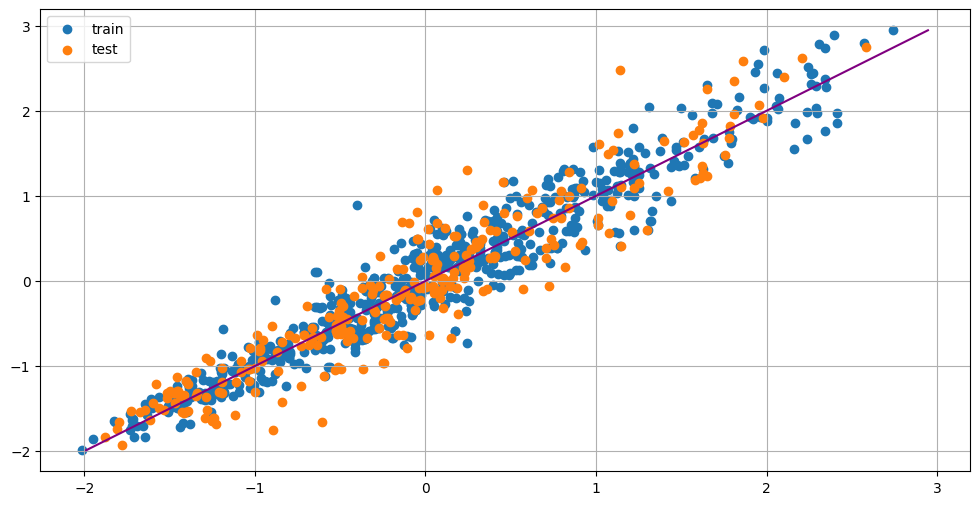

In [57]:
plt.figure(figsize=(12, 6))
plt.scatter(train_pred, big_y_train, label='train')
plt.scatter(test_pred, big_y_test, label='test')
values = np.linspace(Y_np.min(), Y_np.max())
plt.plot(values, values, color='purple')
plt.grid()
plt.legend()
plt.show()

y = y_pred * 0.9968313574790955


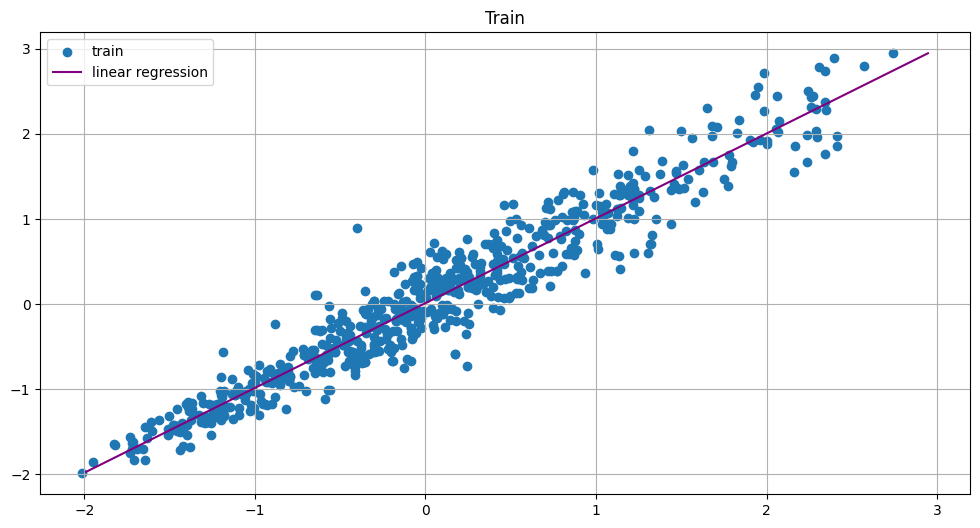

In [66]:
from sklearn.linear_model import LinearRegression

lin_regr = LinearRegression()

lin_regr.fit(train_pred.reshape(-1, 1), big_y_train.to_numpy().reshape(-1, 1))
lin_preds = lin_regr.predict(values.reshape(-1, 1)).reshape(-1)

plt.figure(figsize=(12, 6))
plt.scatter(train_pred, big_y_train, label='train')
print(f'y = y_pred * {lin_regr.coef_[0][0]}')
plt.plot(values, lin_preds, color='purple', label='linear regression')
plt.title('Train')
plt.grid()
plt.legend()
plt.show()

y = y_pred * 1.0047576427459717


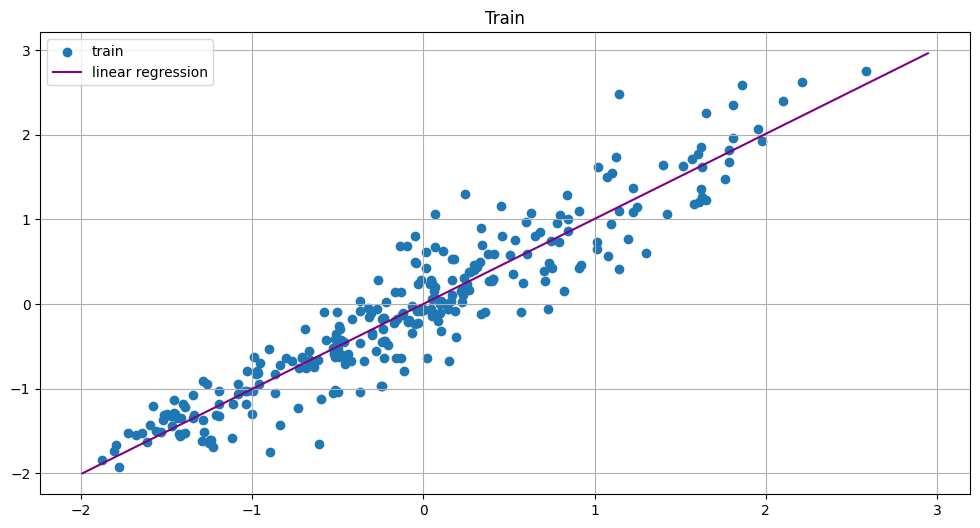

In [67]:
lin_regr = LinearRegression()

lin_regr.fit(test_pred.reshape(-1, 1), big_y_test.to_numpy().reshape(-1, 1))
lin_preds = lin_regr.predict(values.reshape(-1, 1)).reshape(-1)

plt.figure(figsize=(12, 6))
plt.scatter(test_pred, big_y_test, label='train')
print(f'y = y_pred * {lin_regr.coef_[0][0]}')
plt.plot(values, lin_preds, color='purple', label='linear regression')
plt.title('Train')
plt.grid()
plt.legend()
plt.show()

In [55]:
from sklearn.metrics import r2_score

print(f'Train R^2 = {r2_score(big_y_train, train_pred):.3f}')
print(f'Test R^2 = {r2_score(big_y_test, test_pred):.3f}')

Train R^2 = 0.929
Test R^2 = 0.883


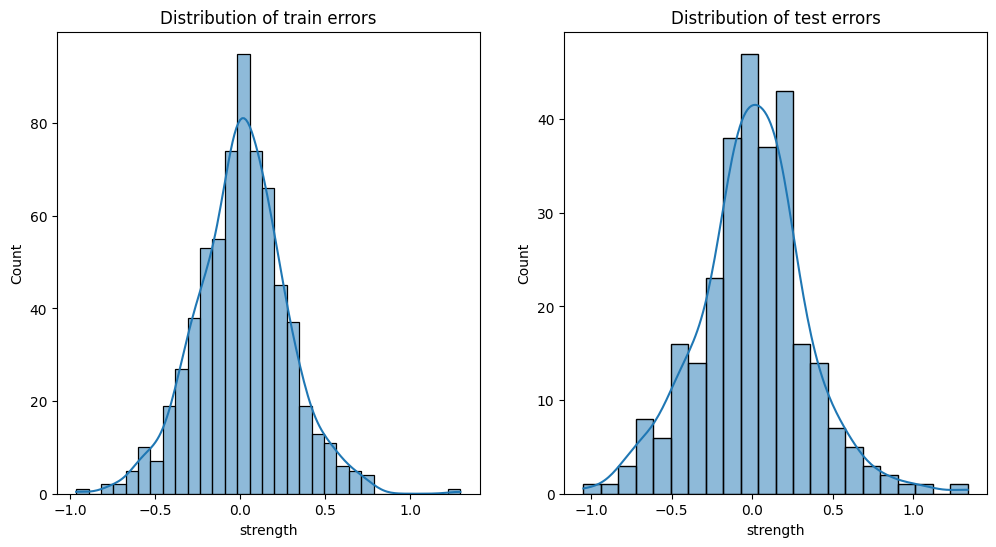

In [77]:
fig, ax = plt.subplots(1, 2)
fig.set_figheight(6)
fig.set_figwidth(12)
sns.histplot(big_y_train - train_pred, kde=True, ax=ax[0])
sns.histplot(big_y_test - test_pred, kde=True, ax=ax[1])
ax[0].set_title('Distribution of train errors')
ax[1].set_title('Distribution of test errors')
plt.show()

### 5.2 Оценка важности признаков

In [124]:
weights = np.zeros((len(big_x_train.columns), 1))
names = np.array(big_x_train.columns)

layer_w = model.layers[0].get_weights()[0]
print(layer_w.shape)
for i in range(len(names)):
    weights[i][0] += np.sum(layer_w[i])
print(list(zip(names, weights.reshape(-1))))

(7, 50)
[('cement', -13.703804969787598), ('slag', -8.008419036865234), ('water', 9.771476745605469), ('plastic', -12.991092681884766), ('coarse', -2.9240660667419434), ('fine', 14.569056510925293), ('age', 19.057456970214844)]


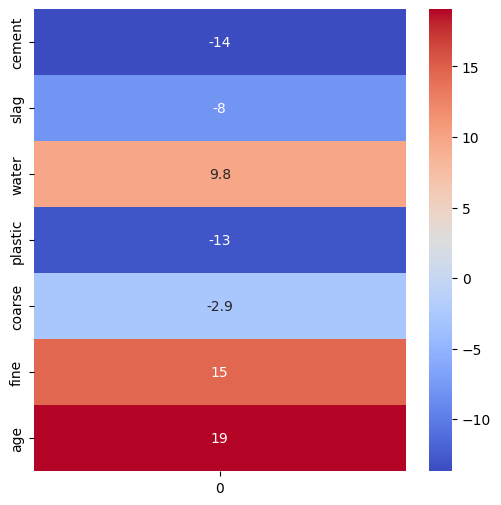

In [120]:
fig, ax = plt.subplots()
fig.set_figwidth(6)
fig.set_figheight(6)
sns.heatmap(weights, yticklabels=names, cmap='coolwarm', ax=ax, annot=True)
plt.show()

### 5.3 Выводы

Оптимизаторы эти извращённые мне не нужны, Адам лучше всех